In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import joblib
import time
import pickle
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer

from multioutput_functions import *

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

In [5]:
def f1score_jd(true_Y,pred_Y):
    f1_score=[]
    weights=[]
    totlength = len(true_Y)

    for value in [0,1]:
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        match_value = np.where(np.array(true_Y) == pred_Y)[0]
        postn_value = np.where(true_Y ==  value)[0]
        weights.append(len(postn_value)/totlength)
        for i in postn_value:
            if i in match_value:
                tp +=1
            elif i not in match_value:
                fn +=1
        for i in match_value:
            if i not in postn_value:
                tn +=1
        fp = len(true_Y)-tn-fn-tp

        if tp==0:
            precision = 0
            recall = 0
            f1_score = 0
        else:
            precision = tp/(fp+tp)
            recall    = tp/(fn+tp)
            f1_score.append(2*precision*recall/(precision + recall))
    
    f1_weighted = np.array(f1_score)*np.array(weights)

    # return np.nanmean(f1_score)
    return np.nansum(f1_weighted)

In [6]:
def RF_optimize(DF_,wave,telluric=False,optimization=False,jobs=-1,Group=''):

    Bardalez = ['G1','Bardalez']
    Burgasser = ['G2','Burgasser']
    alltypes = ['G3','all','']
    earlytypes = ['G4','late']
    if Group in Bardalez:
        typerange=[[16,27],[31,38]]
    elif Group in Burgasser:
        typerange=[[25,32],[32,38]]
    elif Group in alltypes:
        typerange=[[16,39],[16,39]]
    elif Group in earlytypes:
        typerange=[[16,30],[16,32]]
    elif (type(Group)==list):
        if len(Group)==2:
            if (len(Group[0])==2)&(len(Group[1])==2):
                typerange=Group
    else:
        return print('Error. Select a valid group')
    
    
    sins=DF_[DF_.num_class==0]
    bins=DF_[DF_.num_class==1]
    
    if 'primary_type' in DF_.columns:
        bins = bins[bins.primary_type>=typerange[0][0]]
        bins = bins[bins.primary_type<=typerange[0][1]]
        bins = bins[bins.secondary_type>=typerange[1][0]]
        bins = bins[bins.secondary_type<=typerange[1][1]]
    else:
        return print('Include a column with the primary and secondary types for the binaries')

    if 'system_interpolated_flux' in DF_.columns:
        fluxcolname = 'system_interpolated_flux'
    elif 'FLUX' in DF_.columns:
        fluxcolname = 'FLUX'
    else: return print('Missing flux column')
    if 'system_interpolated_noise' in DF_.columns:
        noisecolname = 'system_interpolated_noise'
    elif 'UNCERTAINTY' in DF_.columns:
        noisecolname = 'UNCERTAINTY'
    else: return print('Missing noise column')

    bin_types=[]
    for flux_i,noise_i in zip(bins[fluxcolname],bins[noisecolname]):
        bin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))

    sin_types=[]
    for flux_i,noise_i in zip(sins[fluxcolname],sins[noisecolname]):
        sin_types.append(typeToNum(fast_classify(wave,flux_i,noise_i)))
    sin_types = np.array(sin_types)
    sins = sins[(sin_types>=min(bin_types)) & (sin_types<=max(bin_types))]
    
    DF_ = pd.concat([sins,bins.drop(['primary_type','secondary_type'],axis=1)],axis=0)


    RSEED = 42  

    feats = ['flux_' + str(k) for k in range(409)]

    
    X0 = np.array(DF_[feats]) #data
    y0 = np.array(DF_['num_class']) #labels 

    X_train, X_test, y_train, y_test = train_test_split(X0,y0,train_size=0.7, random_state=RSEED, shuffle=True)
    if telluric:
        tm = np.logical_or(np.logical_and(wave > 1.35,wave < 1.42), np.logical_and(wave > 1.8,wave < 1.95))
        X_train = np.array([X_train[i][~tm] for i in range(len(X_train))])
        X_test = np.array([X_test[i][~tm] for i in range(len(X_test))])
    data_test = {'X_test':X_test,
                'y_test':y_test}

    param_grid = dict(n_estimators=[int(i) for i in np.linspace(1,151,76)],max_depth=[15,25,None])
    custom_scorer = make_scorer(f1score_jd, greater_is_better=True)
    RF = RandomForestClassifier()
    grid_search = RandomizedSearchCV(RF, param_grid, n_jobs=-1, n_iter=12, scoring=custom_scorer)

    grid_search.fit(X_train, y_train)
    return grid_search, data_test

In [10]:
with open('data/SinDF_low.pickle', 'rb') as f:
        SinDF_low=pickle.load(f)
with open('data/BinDF_low.pickle', 'rb') as f:
        BinDF_low = pickle.load(f)
# BinDF_low.drop(['primary_type','secondary_type'],axis=1,inplace=True)

num_class=[]
for i in range(len(BinDF_low)):
    num_class.append(1)
BinDF_low["num_class"]=num_class

num_class=[]
for i in range(len(SinDF_low)):
    num_class.append(0)
SinDF_low["num_class"]=num_class

DF_low = pd.concat([SinDF_low,BinDF_low],axis=0)

In [11]:
wave = DF_low['WAVE'].iloc[0]

In [12]:
start = time.time()
grid_low_G1, data_low_G1 = RF_optimize(DF_low, wave, Group='G1')
RF_low_G1 = grid_low_G1.best_estimator_
X_low_G1 = data_low_G1['X_test']
y_low_G1 = data_low_G1['y_test']
z_low_G1 = RF_low_G1.predict(X_low_G1)
end = time.time()
print(end-start)

630.4977476596832


In [13]:
grid_low_G1.cv_results_

{'mean_fit_time': array([176.53528681, 193.93888092, 228.09130483,  10.99605088,
        190.26042223, 107.1424974 ,  87.49214149,  21.80022125,
        223.89806657,  39.16183619, 168.76604428, 141.79970398]),
 'std_fit_time': array([3.39031342, 3.34717465, 3.06362739, 1.18460264, 4.71909449,
        1.22158122, 0.4684465 , 0.55893522, 3.49168336, 1.13752436,
        4.03080566, 1.68283558]),
 'mean_score_time': array([1.14825554, 1.12966075, 1.32135153, 0.57475233, 1.15253563,
        0.87747478, 0.82739277, 0.64191184, 0.54366565, 0.71936955,
        0.82686286, 0.71703329]),
 'std_score_time': array([0.05723035, 0.0172988 , 0.05976296, 0.0375997 , 0.04219735,
        0.0143403 , 0.02195418, 0.02922976, 0.12477732, 0.07473815,
        0.14792396, 0.11168662]),
 'param_n_estimators': masked_array(data=[93, 121, 145, 5, 117, 55, 53, 11, 123, 23, 89, 77],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
       

In [14]:
f1score_jd(y_low_G1,z_low_G1)

0.9793462597903009

In [15]:
grid_low_G1.cv_results_['mean_test_score']

array([0.97784903, 0.96750075, 0.9676922 , 0.9652512 , 0.96729591,
       0.97785143, 0.96690764, 0.97437226, 0.9768016 , 0.96545813,
       0.97754802, 0.97659967])

The raw features produce a model with precision ~0.9985
{'0': {'precision': 0.9742228961334344, 'recall': 0.9995555061673519, 'f1-score': 0.9867266344888109, 'support': 17998}, '1': {'precision': 0.9984939759036144, 'recall': 0.9176470588235294, 'f1-score': 0.9563649477100612, 'support': 5780}, 'accuracy': 0.9796450500462612, 'macro avg': {'precision': 0.9863584360185245, 'recall': 0.9586012824954406, 'f1-score': 0.9715457910994361, 'support': 23778}, 'weighted avg': {'precision': 0.9801227548714122, 'recall': 0.9796450500462612, 'f1-score': 0.9793462597903009, 'support': 23778}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

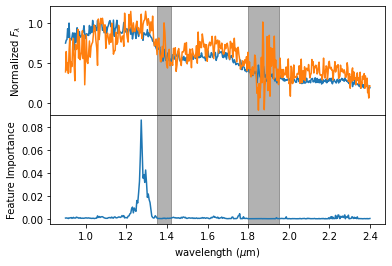

In [16]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G1, z_low_G1)))
class_report_low_G1 = classification_report(y_low_G1,z_low_G1, digits=4, output_dict=True)
print(class_report_low_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave),list(SinDF_low.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_low.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_low_G1.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9985
{'0': {'precision': 0.9742228961334344, 'recall': 0.9995555061673519, 'f1-score': 0.9867266344888109, 'support': 17998}, '1': {'precision': 0.9984939759036144, 'recall': 0.9176470588235294, 'f1-score': 0.9563649477100612, 'support': 5780}, 'accuracy': 0.9796450500462612, 'macro avg': {'precision': 0.9863584360185245, 'recall': 0.9586012824954406, 'f1-score': 0.9715457910994361, 'support': 23778}, 'weighted avg': {'precision': 0.9801227548714122, 'recall': 0.9796450500462612, 'f1-score': 0.9793462597903009, 'support': 23778}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

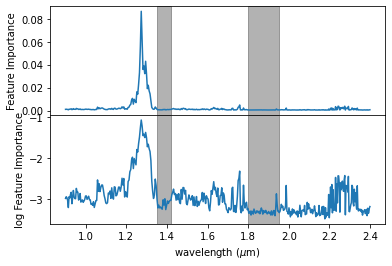

In [35]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G1, z_low_G1)))
class_report_low_G1 = classification_report(y_low_G1,z_low_G1, digits=4, output_dict=True)
print(class_report_low_G1)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave), list(RF_low_G1.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_low_G1.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [17]:
start = time.time()
grid_low_G2, data_low_G2 = RF_optimize(DF_low, wave, Group='G2')
RF_low_G2 = grid_low_G2.best_estimator_
X_low_G2 = data_low_G2['X_test']
y_low_G2 = data_low_G2['y_test']
z_low_G2 = RF_low_G2.predict(X_low_G2)
end = time.time()
print(end-start)

648.4062128067017


In [18]:
grid_low_G2.cv_results_

{'mean_fit_time': array([ 89.74389124, 228.77470226, 129.15903525, 106.18244858,
         80.22887292,  15.8185915 ,   1.77756376, 226.75760908,
         42.13484869, 197.10189018, 159.5168407 , 104.87598963]),
 'std_fit_time': array([ 1.23149221,  1.08747283,  1.81550154,  0.81262912,  0.31297947,
         0.33024093,  0.09543864,  1.45477246,  0.8068674 ,  1.61696521,
         0.89321303, 29.12247372]),
 'mean_score_time': array([0.73274412, 1.17812963, 0.8387363 , 0.78833065, 0.74110842,
        0.53854489, 0.49115562, 1.10811391, 0.60051088, 0.98577075,
        0.98478899, 0.48421297]),
 'std_score_time': array([0.02023374, 0.06036675, 0.02304616, 0.02017146, 0.05103453,
        0.01825072, 0.00885498, 0.04139797, 0.01438526, 0.11469052,
        0.05909882, 0.25642524]),
 'param_n_estimators': masked_array(data=[57, 149, 89, 75, 53, 11, 1, 149, 27, 129, 105, 107],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, Fa

In [19]:
f1score_jd(y_low_G2,z_low_G2)

0.9896835121084866

In [20]:
grid_low_G2.cv_results_['mean_test_score']

array([0.98872474, 0.98921813, 0.98638241, 0.98625661, 0.98827445,
       0.98359337, 0.94520294, 0.98915229, 0.98788675, 0.98911481,
       0.98870522, 0.98905656])

The raw features produce a model with precision ~0.9953
{'0': {'precision': 0.9888338833883389, 'recall': 0.999166296131614, 'f1-score': 0.9939732389693685, 'support': 17992}, '1': {'precision': 0.9953095684803002, 'recall': 0.9400472533963379, 'f1-score': 0.9668894289185906, 'support': 3386}, 'accuracy': 0.9898026008045654, 'macro avg': {'precision': 0.9920717259343195, 'recall': 0.9696067747639759, 'f1-score': 0.9804313339439796, 'support': 21378}, 'weighted avg': {'precision': 0.9898595485451067, 'recall': 0.9898026008045654, 'f1-score': 0.9896835121084866, 'support': 21378}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

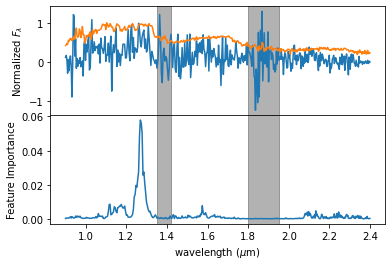

In [21]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G2, z_low_G2)))
class_report_low_G2 = classification_report(y_low_G2,z_low_G2, digits=4, output_dict=True)
print(class_report_low_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave),list(SinDF_low.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_low.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_low_G2.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9953
{'0': {'precision': 0.9888338833883389, 'recall': 0.999166296131614, 'f1-score': 0.9939732389693685, 'support': 17992}, '1': {'precision': 0.9953095684803002, 'recall': 0.9400472533963379, 'f1-score': 0.9668894289185906, 'support': 3386}, 'accuracy': 0.9898026008045654, 'macro avg': {'precision': 0.9920717259343195, 'recall': 0.9696067747639759, 'f1-score': 0.9804313339439796, 'support': 21378}, 'weighted avg': {'precision': 0.9898595485451067, 'recall': 0.9898026008045654, 'f1-score': 0.9896835121084866, 'support': 21378}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

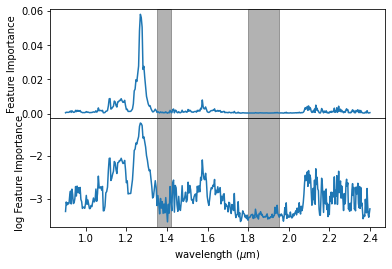

In [34]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G2, z_low_G2)))
class_report_low_G2 = classification_report(y_low_G2,z_low_G2, digits=4, output_dict=True)
print(class_report_low_G2)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave), list(RF_low_G2.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_low_G2.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [22]:
start = time.time()
grid_low_G3, data_low_G3 = RF_optimize(DF_low, wave, Group='G3')
RF_low_G3 = grid_low_G3.best_estimator_
X_low_G3 = data_low_G3['X_test']
y_low_G3 = data_low_G3['y_test']
z_low_G3 = RF_low_G3.predict(X_low_G3)
end = time.time()
print(end-start)

798.9486131668091


In [23]:
grid_low_G3.cv_results_

{'mean_fit_time': array([264.59130359,  32.78231144,  44.70256672,  21.85113692,
        224.22572742, 287.37322607, 139.86946254,  45.25177159,
        213.49677024, 170.69239116, 117.37072334, 127.16859379]),
 'std_fit_time': array([ 4.03378746,  0.80912394,  0.91377097,  0.92747428,  1.3981014 ,
         2.89736527,  1.37409   ,  0.98438027,  3.61760092,  2.24873922,
         2.11686814, 16.76888765]),
 'mean_score_time': array([2.0368155 , 1.20944948, 1.27999449, 1.19748101, 1.81930027,
        2.223873  , 1.55700874, 1.32575936, 1.36230869, 1.64463677,
        1.30771208, 0.68863282]),
 'std_score_time': array([0.05708913, 0.01847827, 0.0299309 , 0.01304366, 0.03543836,
        0.1451893 , 0.05097355, 0.05460921, 0.39770089, 0.22193096,
        0.18245259, 0.10804236]),
 'param_n_estimators': masked_array(data=[91, 13, 15, 9, 95, 121, 57, 15, 89, 57, 49, 69],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False]

In [24]:
f1score_jd(y_low_G3,z_low_G3)

0.9656134575231244

In [25]:
grid_low_G3.cv_results_['mean_test_score']

array([0.96326474, 0.93808528, 0.95128654, 0.93313977, 0.94589045,
       0.9457948 , 0.94440747, 0.9497748 , 0.94518389, 0.96148247,
       0.944375  , 0.9621245 ])

The raw features produce a model with precision ~0.9835
{'0': {'precision': 0.9492058415947127, 'recall': 0.9842489222946833, 'f1-score': 0.966409811156935, 'support': 18094}, '1': {'precision': 0.9834840055632823, 'recall': 0.9468310644945325, 'f1-score': 0.9648095508811824, 'support': 17924}, 'accuracy': 0.9656282969626298, 'macro avg': {'precision': 0.9663449235789975, 'recall': 0.9655399933946078, 'f1-score': 0.9656096810190586, 'support': 36018}, 'weighted avg': {'precision': 0.9662640294722362, 'recall': 0.9656282969626298, 'f1-score': 0.9656134575231244, 'support': 36018}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

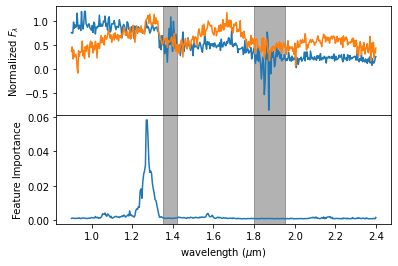

In [26]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G3, z_low_G3)))
class_report_low_G3 = classification_report(y_low_G3,z_low_G3, digits=4, output_dict=True)
print(class_report_low_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave),list(SinDF_low.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_low.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_low_G3.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9835
{'0': {'precision': 0.9492058415947127, 'recall': 0.9842489222946833, 'f1-score': 0.966409811156935, 'support': 18094}, '1': {'precision': 0.9834840055632823, 'recall': 0.9468310644945325, 'f1-score': 0.9648095508811824, 'support': 17924}, 'accuracy': 0.9656282969626298, 'macro avg': {'precision': 0.9663449235789975, 'recall': 0.9655399933946078, 'f1-score': 0.9656096810190586, 'support': 36018}, 'weighted avg': {'precision': 0.9662640294722362, 'recall': 0.9656282969626298, 'f1-score': 0.9656134575231244, 'support': 36018}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

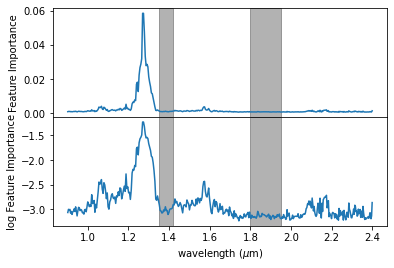

In [32]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G3, z_low_G3)))
class_report_low_G3 = classification_report(y_low_G3,z_low_G3, digits=4, output_dict=True)
print(class_report_low_G3)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave), list(RF_low_G3.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_low_G3.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

In [27]:
start = time.time()
grid_low_G4, data_low_G4 = RF_optimize(DF_low, wave, Group='G4')
RF_low_G4 = grid_low_G4.best_estimator_
X_low_G4 = data_low_G4['X_test']
y_low_G4 = data_low_G4['y_test']
z_low_G4 = RF_low_G4.predict(X_low_G4)
end = time.time()
print(end-start)

730.9133067131042


In [28]:
grid_low_G4.cv_results_

{'mean_fit_time': array([211.16245537,  52.15905943,  97.6155828 , 173.42170749,
        150.50172834,  28.10189886, 132.13580894,  16.96214352,
        240.73029919,  10.71225991, 173.78561325, 175.46689568]),
 'std_fit_time': array([1.44653517, 1.48280036, 1.39698096, 2.14871983, 1.4810619 ,
        0.48314136, 3.54753371, 0.83587729, 2.11177653, 0.14650275,
        2.89054302, 6.28640996]),
 'mean_score_time': array([1.1979599 , 0.66013441, 0.79445939, 1.18156033, 1.04112873,
        0.55824294, 0.95804577, 0.52704434, 1.02281327, 0.50467763,
        1.3220891 , 0.7257102 ]),
 'std_score_time': array([0.03664405, 0.00759411, 0.01388366, 0.11804544, 0.04321871,
        0.00549773, 0.03113327, 0.00702286, 0.19631444, 0.00441943,
        0.10815285, 0.31838917]),
 'param_n_estimators': masked_array(data=[145, 35, 79, 119, 123, 19, 87, 11, 147, 7, 107, 115],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
     

In [29]:
f1score_jd(y_low_G4,z_low_G4)

0.974237705224698

In [30]:
max(grid_low_G4.cv_results_['mean_test_score'])

0.9714246740483474

The raw features produce a model with precision ~0.9879
{'0': {'precision': 0.9682616661278155, 'recall': 0.9943555973659455, 'f1-score': 0.9811351661252015, 'support': 18071}, '1': {'precision': 0.9879446873891975, 'recall': 0.9341752346893161, 'f1-score': 0.9603078867252571, 'support': 8948}, 'accuracy': 0.9744254043450905, 'macro avg': {'precision': 0.9781031767585064, 'recall': 0.9642654160276307, 'f1-score': 0.9707215264252294, 'support': 27019}, 'weighted avg': {'precision': 0.9747801780729964, 'recall': 0.9744254043450905, 'f1-score': 0.9742377052246981, 'support': 27019}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

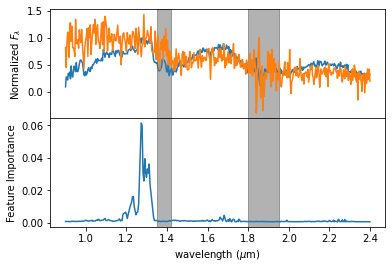

In [31]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G4, z_low_G4)))
class_report_low_G4 = classification_report(y_low_G4,z_low_G4, digits=4, output_dict=True)
print(class_report_low_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave),list(SinDF_low.system_interpolated_flux.iloc[Sin_i]),label='single')
ax[0].plot(list(wave),list(BinDF_low.system_interpolated_flux.iloc[Bin_i]),label='binary')
ax[0].set_ylabel('Normalized $F_\\lambda$')
ax[1].plot(list(wave), list(RF_low_G4.feature_importances_)[:409])
ax[1].set_ylabel('Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')

The raw features produce a model with precision ~0.9879
{'0': {'precision': 0.9682616661278155, 'recall': 0.9943555973659455, 'f1-score': 0.9811351661252015, 'support': 18071}, '1': {'precision': 0.9879446873891975, 'recall': 0.9341752346893161, 'f1-score': 0.9603078867252571, 'support': 8948}, 'accuracy': 0.9744254043450905, 'macro avg': {'precision': 0.9781031767585064, 'recall': 0.9642654160276307, 'f1-score': 0.9707215264252294, 'support': 27019}, 'weighted avg': {'precision': 0.9747801780729964, 'recall': 0.9744254043450905, 'f1-score': 0.9742377052246981, 'support': 27019}}


Text(0.5, 0, 'wavelength ($\\mu$m)')

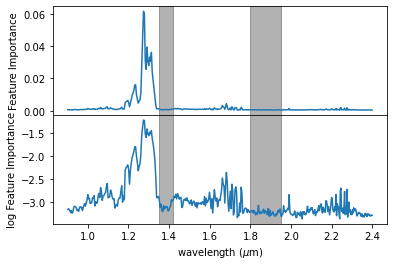

In [33]:
print("The raw features produce a model with precision ~{:.4f}".format(precision_score(y_low_G4, z_low_G4)))
class_report_low_G4 = classification_report(y_low_G4,z_low_G4, digits=4, output_dict=True)
print(class_report_low_G4)
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[1].axvspan(1.35,1.42, alpha=0.3, color='k')
ax[0].axvspan(1.80,1.95, alpha=0.3, color='k')
ax[1].axvspan(1.80,1.95, alpha=0.3, color='k')
Sin_i = random.randint(0,len(SinDF_low))
Bin_i = random.randint(0,len(BinDF_low))
ax[0].plot(list(wave), list(RF_low_G4.feature_importances_)[:409])
ax[0].set_ylabel('Feature Importance')
ax[1].plot(list(wave), np.log10(list(RF_low_G4.feature_importances_)[:409]))
ax[1].set_ylabel('log Feature Importance')
plt.subplots_adjust(hspace=0)
# fig.suptitle('Feature importance and M9+L6 binary template')
plt.xlabel('wavelength ($\mu$m)')